In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt

## Their parameters
- Cpx-only Use mytry of 6, counter to package default, mtry of 1/3 total number of variables. Use ntree of 201
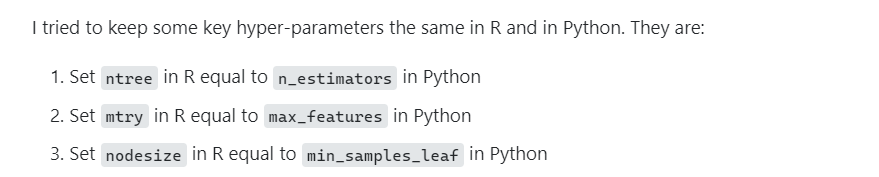
- Cpx-Liq, use mtry of 2/3 of variable. 
- Use 1 cut
- Preprocess the claibration data - use structural formula of Deer et al. 1997. Convert FE2O3 and FeO , go to 100 anhydrous.
- But dont seem to use this?
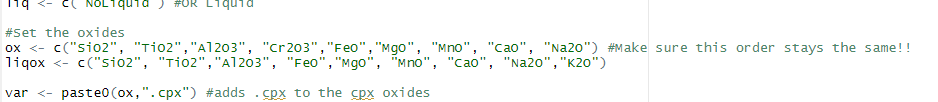

In [2]:
out_train=pt.import_excel('Jorgenson_Input_filtered.xlsx',
                          sheet_name='Jorgenson_Input_filtered_ThBar')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
x_train=Cpx_train_noID_noT.values
y_train_T=out_train_input['T_K']
y_train_P=out_train_input['P_kbar']
Kd_Corin_train=(
    (out_train_input['FeOt_Cpx']/out_train_input['MgO_Cpx'])
/(out_train_input['FeOt_Liq']/out_train_input['MgO_Liq'])
)

In [3]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.pipeline import Pipeline
crit="squared_error"
# Make pipeline

regr_P = ExtraTreesRegressor(n_estimators=201, criterion=crit, 
                             max_features=6, random_state=80) # random_state fixed for reproducibility

regr_T = ExtraTreesRegressor(n_estimators=201, criterion=crit,
                             max_features=6, random_state=280) # random_state fixed for reproducibility

pipeP = Pipeline([
    ('regressor', regr_P)
])

rf_model_P =pipeP.fit(x_train, y_train_P)


initial_types_P=[('float_input', FloatTensorType([None, x_train.shape[1]]))]
model_onnx_P = convert_sklearn(rf_model_P, initial_types=initial_types_P)

pipeT = Pipeline([
    ('regressor', regr_T)
])

rf_model_T =pipeP.fit(x_train, y_train_T)


initial_types_T=[('float_input', FloatTensorType([None, x_train.shape[1]]))]
model_onnx_T = convert_sklearn(rf_model_T, initial_types=initial_types_T)


In [4]:
with open("Jorg21_Cpx_only_Temp.onnx", "wb") as f:
    f.write(model_onnx_T.SerializeToString())

with open("Jorg21_Cpx_only_Press.onnx", "wb") as f:
    f.write(model_onnx_P.SerializeToString())